In [1]:
import pandas as pd
import re
import seaborn as sns
from datetime import datetime

In [2]:
FILEPATH = "data/_chat.txt"

In [3]:
def parse_whatsapp_chat(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    data = []
    pattern = re.compile(
        r"\[(\d{2}/\d{2}/\d{4}), (\d{2}:\d{2}:\d{2})\]\s+(.*?):\s*(.*)"
    )
    current_message = None

    for line in lines:
        match = pattern.search(line)
        if match:
            if current_message:
                data.append(current_message)
            date = match.group(1)
            time = match.group(2)
            sender = match.group(3)
            message = match.group(4)
            current_message = [sender, date, time, message]
        else:
            if current_message:
                current_message[3] += "\n" + line.strip()

    if current_message:
        data.append(current_message)

    df = pd.DataFrame(data, columns=["Sender", "Date", "Time", "Message"])
    return df


def contains_wordle_pattern(text):
    pattern = r"Wordle\s+\d{1,3}(?:,\d{3})*\s+(?:X/6|[1-6]/6)"
    return bool(re.search(pattern, text))


def get_wordle_outcome(text):
    pattern = r"Wordle\s+\d{1,3}(?:,\d{3})*\s+(X/6|[1-6]/6)"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None


def get_wordle_score(outcome):
    score_dict = {
        None: None,
        "X/6": 7,
        "1/6": 1,
        "2/6": 2,
        "3/6": 3,
        "4/6": 4,
        "5/6": 5,
        "6/6": 6,
    }
    return score_dict[outcome]

In [ ]:
# import the data then add new columns and correct datatypes
df = parse_whatsapp_chat(FILEPATH)
df["Worlde"] = df["Message"].apply(contains_wordle_pattern)
df["Outcome"] = df["Message"].apply(get_wordle_outcome)
df["Score"] = df["Outcome"].apply(get_wordle_score)
df["Timestamp"] = df["Date"] + " " + df["Time"]
df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True)
df = df.set_index("Timestamp")
df["Hour"] = df.index.hour
df["Day"] = df.index.day_name()
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

In [5]:
df

,Sender,Date,Time,Message,Worlde,Outcome,Score,Hour,Day
Timestamp,,,,,,,,,
2024-09-04 19:48:48,Evan Jenkins,2024-09-04,19:48:48,I like the new nick cave song,False,None,NaN,19,Wednesday
2024-09-04 19:50:05,Aled Meredith,2024-09-04,19:50:05,Wild God??,False,None,NaN,19,Wednesday
2024-09-04 19:50:13,Aled Meredith,2024-09-04,19:50:13,‎image omitted,False,None,NaN,19,Wednesday
2024-09-04 19:50:37,Evan Jenkins,2024-09-04,19:50:37,Did you do that?,False,None,NaN,19,Wednesday
2024-09-04 19:50:47,Evan Jenkins,2024-09-04,19:50:47,‘Long dark night’,False,None,NaN,19,Wednesday
...,...,...,...,...,...,...,...,...,...
2025-11-05 09:05:41,Aled Meredith,2025-11-05,09:05:41,Bummer Ev,False,None,NaN,9,Wednesday
2025-11-05 09:05:46,Aled Meredith,2025-11-05,09:05:46,Well done Jon!,False,None,NaN,9,Wednesday
2025-11-05 15:58:16,Evan Jenkins,2025-11-05,15:58:16,‎sticker omitted,False,None,NaN,15,Wednesday


In [ ]:
# filter for only messages sharing Wordle outcomes
df_wordle_messages = df[df["Worlde"]]
# filter to messages after May 13th (when we started sending daily updates to the chat)
df_wordle_messages = df_wordle_messages[
    df_wordle_messages.index > datetime(2025, 5, 12)
]
# df_wordle_messages = df_wordle_messages[
#     df_wordle_messages.index < datetime(2025, 9, 21)
# ]

In [7]:
# who has sent the most Wordle meessages to the group chat?
wordle_messages_count = (
    df_wordle_messages[["Sender", "Outcome"]]
    .groupby("Sender")
    .count()
    .sort_values("Outcome", ascending=False)
)
wordle_messages_count

,Outcome
Sender,
Aled Meredith,175
Jonathan Roberts,171
Evan Jenkins,166


In [8]:
# which day of the week has best Wordle scores?
mean_score_by_weekday = (
    df_wordle_messages[["Day", "Score"]]
    .groupby("Day")
    .mean()
    .reset_index()
    .sort_values(by="Score")
    .rename(columns={"Score": "Mean Score"})
)
mean_score_by_weekday

,Day,Mean Score
3,Sunday,4.211268
2,Saturday,4.253521
0,Friday,4.260274
5,Tuesday,4.310811
1,Monday,4.405405
6,Wednesday,4.584416
4,Thursday,4.625000


In [9]:
# set plotting themes
sns.set_theme(style="ticks", context="notebook")
sns.set_palette("muted")

<Axes: xlabel='Hour Of The Day', ylabel='Wordle Messages'>

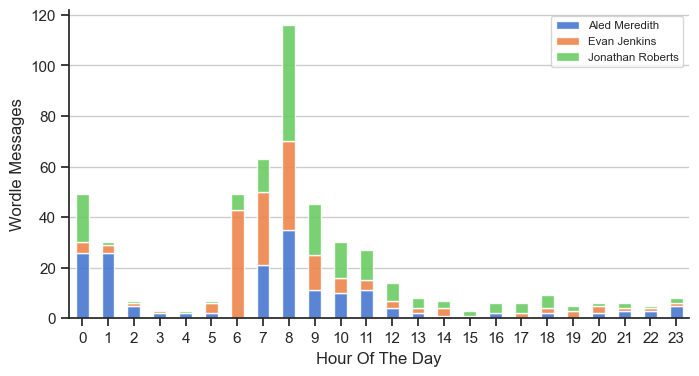

In [10]:

# when are Wordle messages sent to the group chat?
hrs_plt = pd.pivot_table(
    df_wordle_messages,
    values="Outcome",
    index=["Hour"],
    columns=["Sender"],
    aggfunc="count",
).plot.bar(stacked=True, rot=0, figsize=(8, 4), alpha=0.9)
hrs_plt.set_ylabel("Wordle Messages")
hrs_plt.set_xlabel("Hour Of The Day")
hrs_plt.spines[["right", "top"]].set_visible(False)
hrs_plt.grid(axis="y")
hrs_plt.legend(fontsize="x-small")
hrs_plt.get_figure().savefig("output/hour_plot.png", bbox_inches="tight")
hrs_plt


<Axes: ylabel='Outcome'>

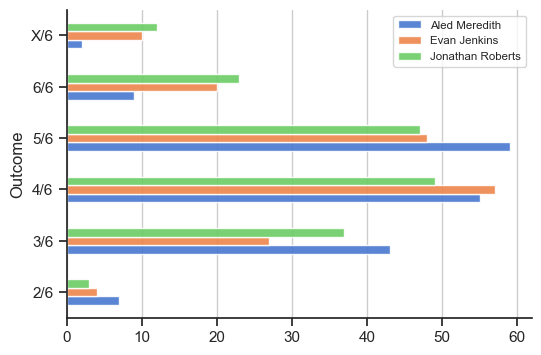

In [11]:
# what's the distribution of Worlde outcomes? (inc. failed guesses)
outcome_plt = (
    df_wordle_messages.groupby(["Sender", "Outcome"])[["Date"]]
    .count()
    .reset_index()
    .pivot(index="Sender", columns="Outcome", values="Date")
    .T.plot.barh(stacked=False, rot=0, figsize=(6, 4), alpha=0.9)
)
outcome_plt.spines[["right", "top"]].set_visible(False)
outcome_plt.grid(axis="x")
outcome_plt.legend(fontsize="x-small")
outcome_plt.get_figure().savefig(
    "output/outcome_plot.png", bbox_inches="tight"
)
outcome_plt

<Axes: xlabel='Date', ylabel='Rolling 14 Day Average Score'>

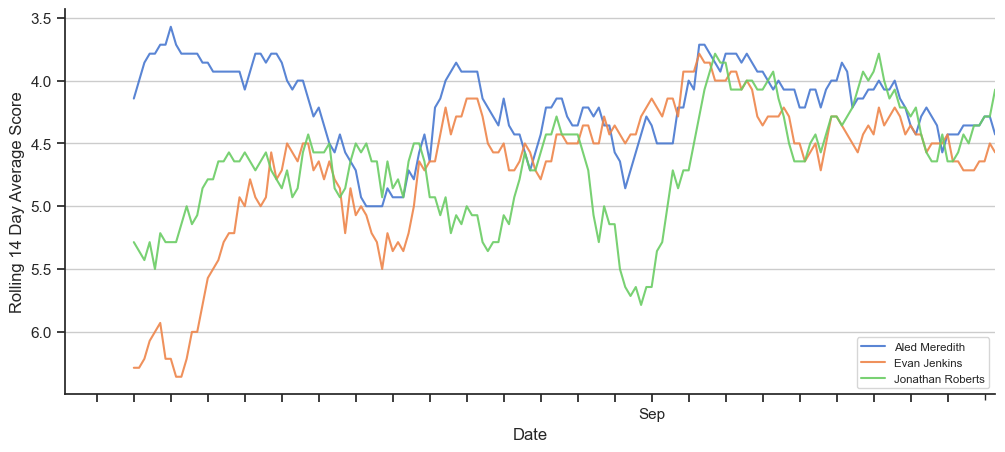

In [12]:
# how have Wordle scores varied over time?
rolling_avg_plt = (
    df_wordle_messages.pivot_table(
        # "scoring" missing values as 8
        values="Score",
        index="Date",
        columns="Sender",
        fill_value=8,
    )
    .rolling(window=14)
    .mean()
    .plot(figsize=(12, 5), alpha=0.9, xticks=pd.date_range(start="2025-05-13", end="2025-10-28", freq="W-MON"))
)
rolling_avg_plt.set_xlabel("Date")
rolling_avg_plt.set_ylabel("Rolling 14 Day Average Score")
rolling_avg_plt.spines[["right", "top"]].set_visible(False)
rolling_avg_plt.grid(axis="y")
rolling_avg_plt.legend(fontsize="x-small")
rolling_avg_plt.invert_yaxis()
rolling_avg_plt.get_figure().savefig(
    "output/rolling_average_plot.png", bbox_inches="tight"
)
rolling_avg_plt

In [13]:
rolling_avg_leaderboard = (
    pd.DataFrame(
        df_wordle_messages.pivot_table(
            # "scoring" missing values as 7
            values="Score",
            index="Date",
            columns="Sender",
            fill_value=8,
        )
        .tail(14)
        .mean()
    )
    .rename(columns={0: "Score"})
    .reset_index()
    .sort_values(by="Score")
)
rolling_avg_leaderboard

,Sender,Score
2,Jonathan Roberts,4.071429
0,Aled Meredith,4.428571
1,Evan Jenkins,4.571429


In [14]:
df_wordle_messages.pivot_table(
    # "scoring" missing values as 8
    values="Score",
    index="Date",
    columns="Sender",
    fill_value=8,
)

Sender,Aled Meredith,Evan Jenkins,Jonathan Roberts
Date,,,
2025-05-13,4.0,8.0,4.0
2025-05-14,5.0,6.0,4.0
2025-05-15,7.0,8.0,8.0
2025-05-16,4.0,6.0,5.0
2025-05-17,4.0,5.0,8.0
...,...,...,...
2025-11-01,5.0,4.0,3.0
2025-11-02,4.0,3.0,3.0
2025-11-03,4.0,4.0,4.0
